In [3]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import datetime as DT
import pandas as pd
import math
import scipy
from IPython.core.debugger import Tracer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.classification import log_loss

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr


import warnings
warnings.filterwarnings('ignore')
#Tracer()()
def prep (a):
    return a.reshape(a.shape[0], 1)
def unprep (a):
    return np.squeeze(a)
def figurefullwidth():
    plt.figure(figsize=(25,5));
def subplot(a):
    plt.subplot(1,3,a);
def subplottitle(a, b):
    ax = plt.subplot(1, 3, a)
    ax.set_title(b)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [6]:
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df



In [62]:
def processfile(csv):
    #load data
    df = pd.read_csv(csv, header= 0)
    del df['order_ref']
    df["inplay"] = df["inplay"].astype(int)
    df["strategy"] = df["strategy"].apply(lambda x: 0 if x == "A" else 1)
    #df["pct_matched"].unique()
    df["pct_matched"].isnull().sum()

    #list of index with nan
    nans = df['pct_matched'].index[df['pct_matched'].apply(np.isnan)]
    #df.loc[3173]
    df = df.drop(df.index[nans])
    r = df['bet_type'].apply(lambda x: pd.Series(x.split('|')))
    del r[0]
    for i in range(0, r.shape[1]):
        df["bet_type" + str(i)] = r[i+1]
    del df["bet_type"]
    df["pct_matched_cat"] = df["pct_matched"].apply(lambda x: 1 if x > 0.5 else -1)
    
    df = df[df["age"] > 0]
    df = df[df["arb_margin"] > 0]
    m1 = "age"
    df[m1+"_orig"] = df[m1]
    df[m1+"_ln"] = df[m1].apply(lambda x: np.log(x))
    df[m1+"_div1"] = df[m1].apply(lambda x: x/1.0)
    df[m1+"_power"] = df[m1].apply(lambda x: np.power(x, 4.0))
    #df["age_ln10"] = df[m1].apply(lambda x: np.log10(x))
    #df["age_ln2"] = df[m1].apply(lambda x: np.log2(x))
    print(df.shape[0])
    df["per_norm"] = np.random.normal(0, 1, df.shape[0])
    #df["per_ln"] = df["per_norm"].apply(lambda x: np.log(x))
    df["per_e"] = df["per_norm"].apply(lambda x: np.exp(x))
    #df["age_exp"] = df["age"].apply(lambda x: np.exp(x))
    
    df = encode_onehot(df, ["bookie", "bet_type0"])
    del df["bet_type1"]
    del df["bet_type2"]
    del df["bet_type3"]
    del df["pct_matched"]
    
    #dfy = pd.concat(df["pct_matched_cat"])
    #dfy = DataFrame()
    dfy = df["pct_matched_cat"]
    del df["pct_matched_cat"]
    #df_y["pct_matched_cat"]
    return df, dfy
def dispdf(df, width):
    print(list(range(0, len(df.columns), width)))
    for i in range(0, len(df.columns), width):
        #print(df.ix[:,0:5].head())
        display(df.ix[:,i:i+min(width, len(df.columns))].head())

In [63]:
dftrain_x, dftrain_y = processfile('/Users/david/notebooks/data/training_set.csv')
dispdf(dftrain_x, 10)
#dftrain_x.head()
dftrain_x.columns
dftrain_y.head()

#dftrain_y.columns

203490
[0, 10, 20, 30]


,strategy,inplay,age,stakes,max_stakes,price,pct_max_stake_reqd_overall,fallback_margin,arb_margin,fallback_cost
0,0,1,896.968049,2.429000,2.429,2.428571,100.000000,0.058410,0.403999,0.345589
1,1,0,0.432858,2.380916,751.490,9.200000,0.316826,-0.176400,0.064876,0.241276
2,1,1,0.064819,13.634291,2338.670,1.240000,0.582993,-0.292514,0.363597,0.656111
3,1,0,107.238326,18.846154,19.820,2.600000,95.086548,0.041334,0.495772,0.454439
4,0,1,38.344546,40.020000,40.020,6.000000,100.000000,0.200951,0.485378,0.284427


,age_orig,age_ln,age_div1,age_power,per_norm,per_e,bet_type0=asian_handicap,bet_type0=both_teams_to_score,bet_type0=clean_sheet,bet_type0=correct_score
0,896.968049,6.799020,896.968049,6.473034e+11,-0.833980,0.434317,0.0,0.0,0.0,0.0
1,0.432858,-0.837347,0.432858,3.510589e-02,-1.076556,0.340767,0.0,0.0,0.0,1.0
2,0.064819,-2.736155,0.064819,1.765273e-05,1.322949,3.754477,0.0,0.0,0.0,0.0
3,107.238326,4.675054,107.238326,1.322513e+08,-0.341313,0.710836,0.0,0.0,0.0,0.0
4,38.344546,3.646612,38.344546,2.161794e+06,0.692710,1.999126,0.0,0.0,0.0,0.0


,bet_type0=correct_score_other,bet_type0=double_chance,bet_type0=draw_no_bet,bet_type0=euro_handicap,bet_type0=match_odds,bet_type0=match_odds_and_btts,bet_type0=match_odds_and_ou,bet_type0=odd_or_even,bet_type0=over_under,bet_type0=team_over_under
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,bet_type0=team_total_goals,bet_type0=team_win_to_nil,bet_type0=total_goals,bet_type0=total_goals_2,bookie=A,bookie=B,bookie=C,bookie=D,bookie=E,bookie=F
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Index(['strategy', 'inplay', 'age', 'stakes', 'max_stakes', 'price',
       'pct_max_stake_reqd_overall', 'fallback_margin', 'arb_margin',
       'fallback_cost', 'age_orig', 'age_ln', 'age_div1', 'age_power',
       'per_norm', 'per_e', 'bet_type0=asian_handicap',
       'bet_type0=both_teams_to_score', 'bet_type0=clean_sheet',
       'bet_type0=correct_score', 'bet_type0=correct_score_other',
       'bet_type0=double_chance', 'bet_type0=draw_no_bet',
       'bet_type0=euro_handicap', 'bet_type0=match_odds',
       'bet_type0=match_odds_and_btts', 'bet_type0=match_odds_and_ou',
       'bet_type0=odd_or_even', 'bet_type0=over_under',
       'bet_type0=team_over_under', 'bet_type0=team_total_goals',
       'bet_type0=team_win_to_nil', 'bet_type0=total_goals',
       'bet_type0=total_goals_2', 'bookie=A', 'bookie=B', 'bookie=C',
       'bookie=D', 'bookie=E', 'bookie=F'],
      dtype='object')

0   -1
1    1
2   -1
3    1
4   -1
Name: pct_matched_cat, dtype: int64

In [9]:
dftrain_x.describe()

,strategy,inplay,age,stakes,max_stakes,price,pct_max_stake_reqd_overall,fallback_margin,arb_margin,fallback_cost,...,bet_type0=team_total_goals,bet_type0=team_win_to_nil,bet_type0=total_goals,bet_type0=total_goals_2,bookie=A,bookie=B,bookie=C,bookie=D,bookie=E,bookie=F
count,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,2.034900e+05,203490.000000,...,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000,203490.000000
mean,0.650867,0.809057,873.898878,27.104012,1598.758216,4.530024,41.351588,-0.041431,5.110810e-01,0.552511,...,0.001430,0.001258,0.002664,0.000029,0.133112,0.541235,0.094191,0.068038,0.039142,0.124281
std,0.476697,0.393045,7463.111904,51.529143,3599.565801,16.970111,43.466261,0.784173,4.758841e-01,0.840963,...,0.037789,0.035447,0.051541,0.005430,0.339697,0.498298,0.292095,0.251811,0.193933,0.329903
min,0.000000,0.000000,0.000045,0.003778,0.027000,1.002475,0.001955,-99.990000,2.430111e-16,-2.996986,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.680004,4.079795,17.007900,1.746269,1.514494,-0.264550,1.980198e-01,0.222831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.867958,11.188307,99.372050,2.120000,16.622931,-0.009348,4.437451e-01,0.374080,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,48.885055,35.080867,1285.000000,3.400000,100.000000,0.248526,6.618134e-01,0.654160,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,326527.341292,11048.490442,106801.560000,1000.000000,100.000000,4.564315,3.030133e+01,100.898579,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
dftest_x, dftest_y = processfile('/Users/david/notebooks/data/testing_set.csv')
dftest_x.head()
dftest_x.columns
dftest_y.head()
#dftest_y.columns

94397


,strategy,inplay,age,stakes,max_stakes,price,pct_max_stake_reqd_overall,fallback_margin,arb_margin,fallback_cost,...,bet_type0=team_total_goals,bet_type0=team_win_to_nil,bet_type0=total_goals,bet_type0=total_goals_2,bookie=A,bookie=B,bookie=C,bookie=D,bookie=E,bookie=F
0,0,1,61.637285,4.330000,4.3300,2.320000,100.000000,0.410490,0.794893,0.384403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,72.134169,28.839624,76.8258,2.219512,37.538982,-0.181804,0.012743,0.194547,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,0.298152,8.228528,5062.0000,1.760000,0.162555,-0.408819,0.010379,0.419198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,0.606424,3.123076,9.8700,8.200000,31.642105,-0.185425,0.119250,0.304676,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,21.131292,25.121046,4050.0000,1.720000,0.620273,0.092797,0.194175,0.101378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Index(['strategy', 'inplay', 'age', 'stakes', 'max_stakes', 'price',
       'pct_max_stake_reqd_overall', 'fallback_margin', 'arb_margin',
       'fallback_cost', 'arb_margin_orig', 'arb_margin_ln', 'arb_margin_div1',
       'arb_margin_power', 'per_norm', 'per_e', 'bet_type0=asian_handicap',
       'bet_type0=both_teams_to_score', 'bet_type0=clean_sheet',
       'bet_type0=correct_score', 'bet_type0=correct_score_other',
       'bet_type0=double_chance', 'bet_type0=draw_no_bet',
       'bet_type0=euro_handicap', 'bet_type0=match_odds',
       'bet_type0=match_odds_and_btts', 'bet_type0=match_odds_and_ou',
       'bet_type0=odd_or_even', 'bet_type0=over_under',
       'bet_type0=team_over_under', 'bet_type0=team_total_goals',
       'bet_type0=team_win_to_nil', 'bet_type0=total_goals',
       'bet_type0=total_goals_2', 'bookie=A', 'bookie=B', 'bookie=C',
       'bookie=D', 'bookie=E', 'bookie=F'],
      dtype='object')

0    1
1    1
2    1
3   -1
4    1
Name: pct_matched_cat, dtype: int64

In [ ]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh
def plot(x):
    fig, axes = plt.subplots(nrows=2)
    for ax, func in zip(axes, [mad_based_outlier]):
        sns.distplot(x, ax=ax, rug=False, hist=False)
        outliers = x[func(x)]
        print("outliers", len(outliers))
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    #axes[1].set_title('MAD-based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)
    plt.show()

#sns.set_style("whitegrid")
#sns.boxplot(dftrain_x[dftrain_x.columns[2]])
for i in [10,11]:
    print(dftrain_x.columns[i])
    plot(dftrain_x[dftrain_x.columns[i]])


Read in the Data

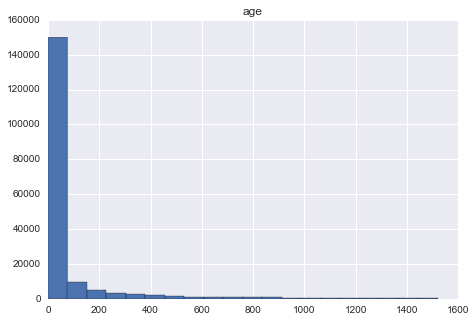

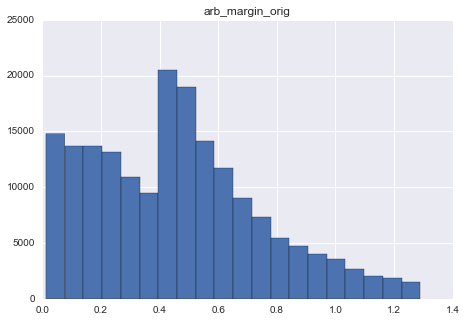

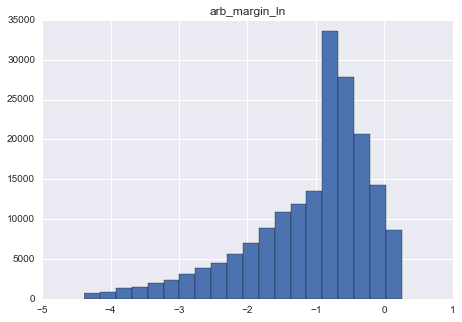

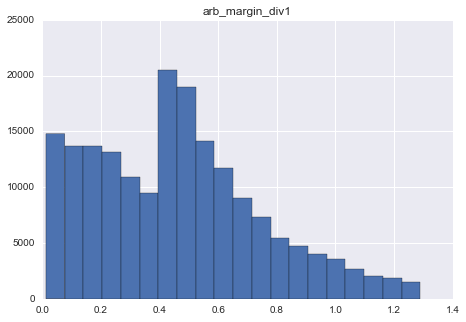

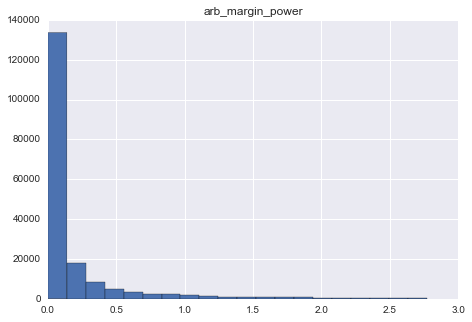

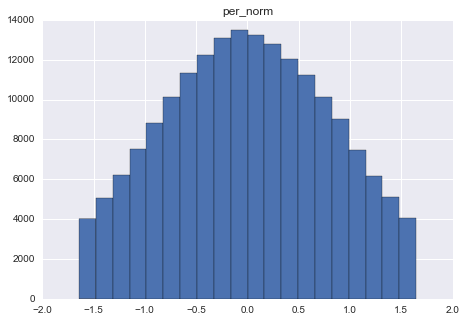

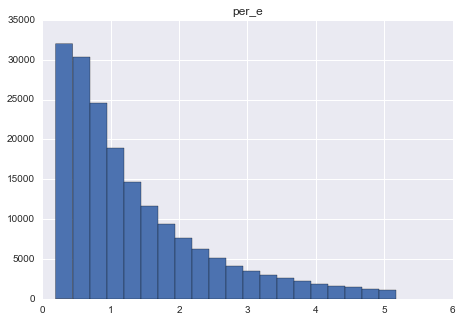

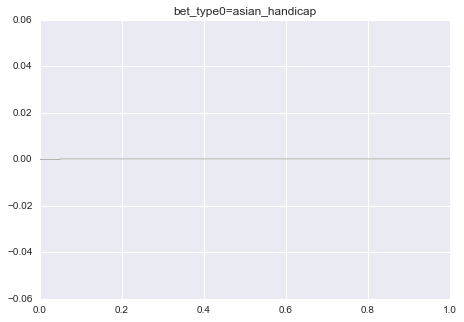

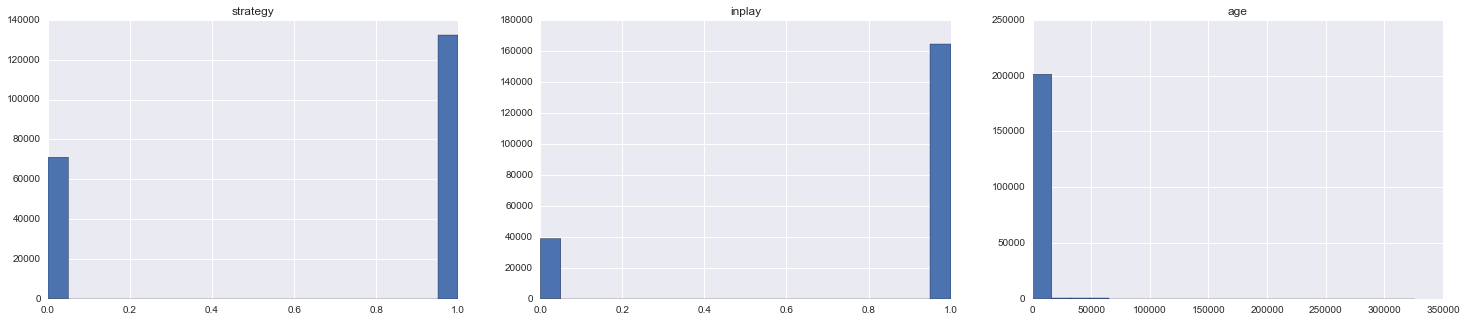

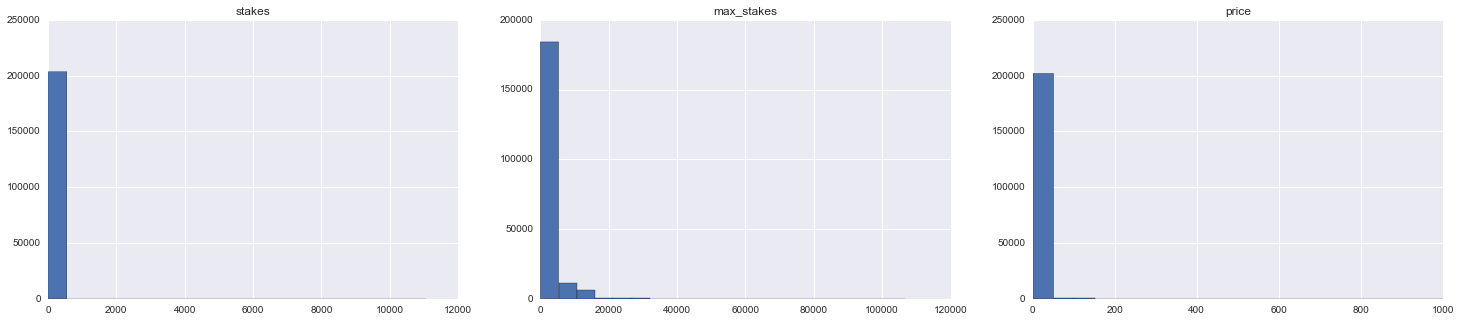

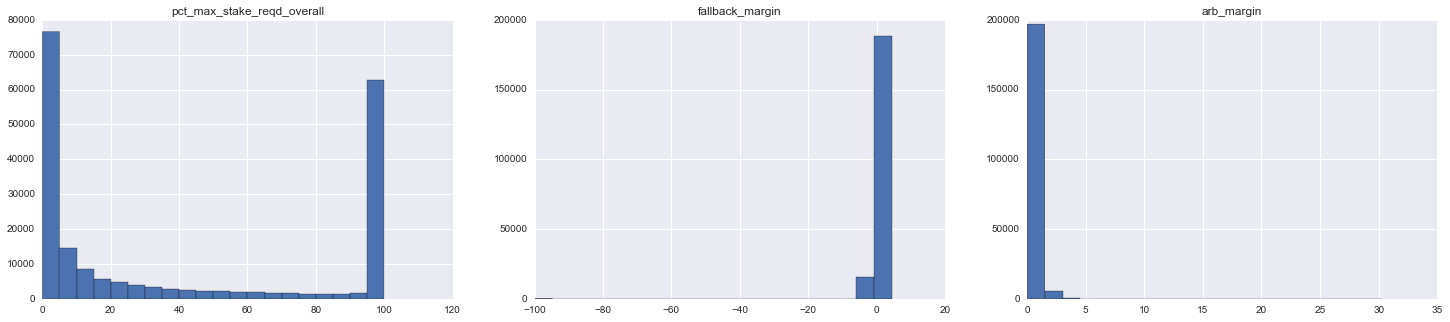

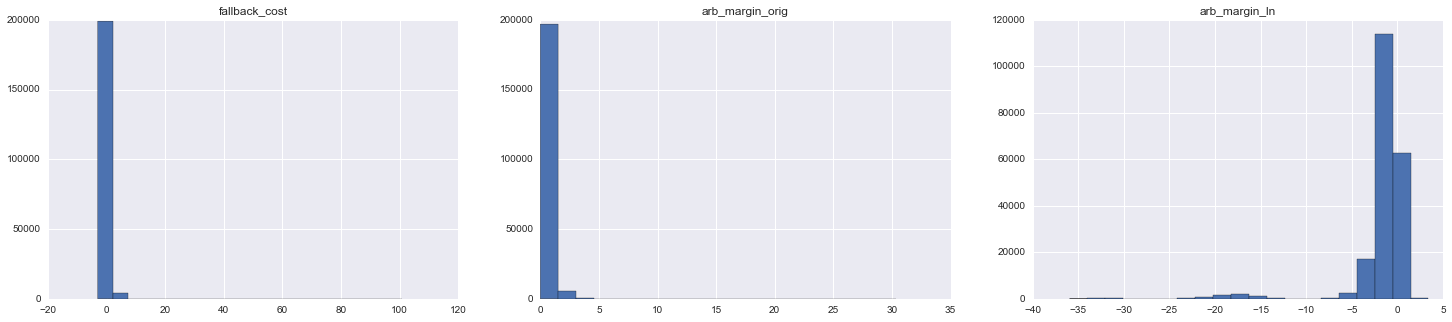

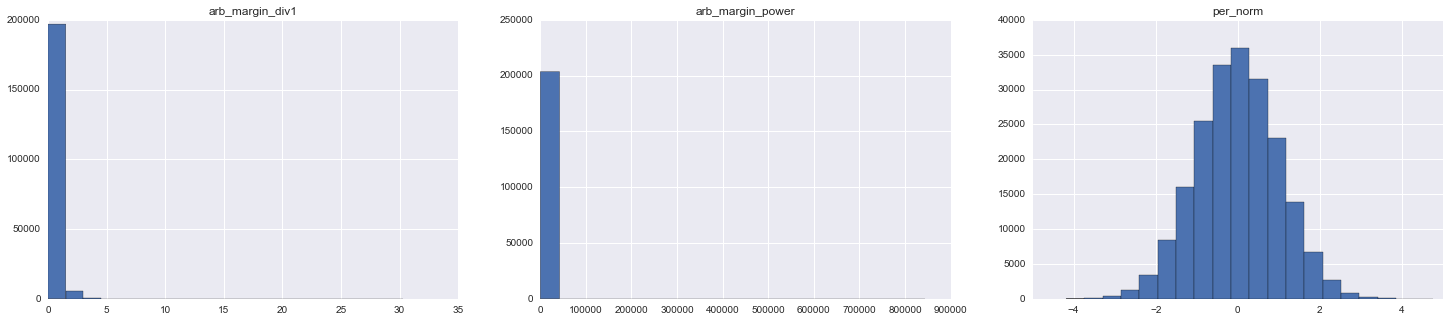

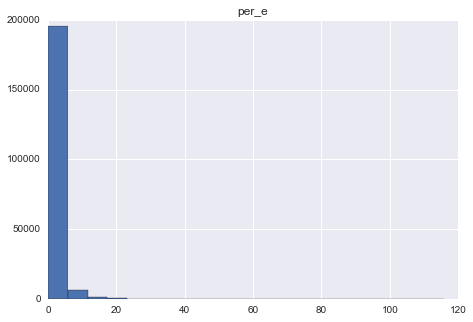

In [12]:
def plotcolnumericalquartiles(df, cols, limits=[25, 75]):
    
    c=df.columns
    a = 0
    for i in cols:
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        
        per = np.percentile(df[c[i]], limits)
        vals = list(filter(lambda x: x > per[0] and x < per[1], df[c[i]]))
        plt.hist(vals, bins=20)
        subplottitle(a+1, c[i])
        a+=1
        if(a==3):
            a = 0

#examine the numberical categories
def plotcolnumerical(df, start=0, end=0):
    if(end == 0):
        end=len(df.columns)
    c=df.columns
    a = 0
    for i in range(start, end):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        #mx = df[c[i]].max()
        #mi = df[c[i]].min()
        #b = int(abs(mx-mi)/20)
        #if b==0:b=1
        #print(mx, mi, b)
        
        _ = df[c[i]].hist(bins=20)
        subplottitle(a+1, c[i])
        a+=1
        if(a==3):
            a = 0


limits = [5,95]
for i in [2, 10, 11, 12, 13, 14, 15, 16]:
    plotcolnumericalquartiles(dftrain_x, [i], limits=limits)

plotcolnumerical(dftrain_x, end=16)

#df[colnum[2]].plot()



#df.boxplot(column='ApplicantIncome', by = 'Education')

In [13]:
#dftrain_x[dftrain_x["age_exp"].apply(lambda x: np.isnan(x))]
#dftrain_x[dftrain_x["age_exp"].apply(lambda x: np.isinf(x))]


In [14]:
#examine the numberical categories
def plotcolnumericalagainst(c):
    a = 0
    for i in range(len(c)):
        for j in range(len(c)):
            if (a == 0):
                figurefullwidth()
            ax = plt.subplot(1, len(c), a + 1)
            x = df[c[i]]
            y = df[c[j]]
            if(x.dtype == "datetime64[ns]"):
                x = [date.to_datetime() for date in x]
            if(y.dtype == "datetime64[ns]"):
                y =  [date.to_datetime() for date in y]
                
            #subplot(a+1)
            #if(df[c[i]].dtype == datetime)
            plt.scatter(x, y, c='b')
            #_ = df[c[i]].hist(bins=50)
            ax.set_ylabel(c[j])
            ax.set_xlabel(c[i])
            #subplottitle(a+1, c[i])
            a += 1
            if (a == len(c) - 1):
                a = 0

#df.dtypes
#import matplotlib.dates as mdates
#mdates.strpdate2num('%Y-%m-%d')
#df[colnum[1]].astype(DT.datetime).values[0]
#df[colnum[1]].astype(DT.datetime).values[0].to_datetime()

#[date.to_datetime() for date in df[colnum[1]]]

#plotcolnumericalagainst(colnum[1:5])
#df.boxplot(column='ApplicantIncome', by = 'Education')

In [15]:
#look at the dist across categories
def plotcolcats(c):
    a = 0
    for i in range(len(c)):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        if(len(df[c[i]].unique())> 50):
            print ("too many cols ",len(df[c[i]].unique()), c[i], i)
        else:
            _ = df[c[i]].value_counts().plot(kind='bar')
        subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0
#plotcolcats(colcat)

In [16]:
#figurefullwidth()
#df[colcat[4]].value_counts()[:100].plot(kind='bar')
#figurefullwidth()
#df[colcat[6]].value_counts().plot(kind='bar')
#figurefullwidth()
#df[colcat[7]].value_counts()[:100].plot(kind='bar')

In [17]:
def plotcolcatsbygroup(s, c):
    a = 0
    for i in range(len(c)):
        #if(a==0):
        #    figurefullwidth()
        #subplot(a+1)
        sizes = df.groupby([s,c[i]]).size().unstack()
        l = len(sizes)
        #print(sizes, )
        if(sizes.shape[1]> 50):
            print ("too many cols ",l, c[i], i)
        else:
            sizes.plot(kind='bar')
        #subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0
#Now we start to see what is significant
#df["Year"] = df["DateOfCall"].map(lambda x: x.year)
#colcat
#df.pivot(index='Year', columns=colcat[0], values='value')
#plotcolcatsbygroup('Year', colcat)

#df.groupby(['Year',colcat[0]]).size().unstack()

#df.pivot_table(index='Year', columns=colcat[0], aggfunc=len, fill_value=0)

#plot cat counts vs numberical
'''figurefullwidth()
subplot(1)
_vc = df[colcat[0]].value_counts()
#.index.tolist()
df["Year"].values.shape
_vc.values.shape
plt.plot(df["Year"].values, _vc.values, c=_vc.index)
#df[colcat[0]].value_counts().values.tolist()
'''

'figurefullwidth()\nsubplot(1)\n_vc = df[colcat[0]].value_counts()\n#.index.tolist()\ndf["Year"].values.shape\n_vc.values.shape\nplt.plot(df["Year"].values, _vc.values, c=_vc.index)\n#df[colcat[0]].value_counts().values.tolist()\n'

In [18]:
#look at the dist across categories
def plotcolcats(c):
    a = 0
    for i in range(10):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        if(len(df[colcat[i]].unique())> 50):
            print ("too many cols ",len(df[colcat[i]].unique()), colcat[i], i)
        else:
            _ = df[colcat[i]].value_counts().plot(kind='bar')
        subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0

In [19]:
def selectcols(df1, cols, split, df2):
    t_cols = [df1.columns[i] for i in cols]
    test_l = int(df1.shape[0] * split)
    #train_l = df1.shape[0] - test_l
    print(t_cols, test_l)
    x_train = df1[t_cols][:test_l]
    x_test = df1[t_cols][test_l:]
    y_train = df2[:test_l]
    y_test = df2[test_l:]
    return x_train, x_test, y_train, y_test

In [54]:
def svc():
    sv = SVC(kernel='linear', gamma=0.1, probability=False)
    tag = "SVC"
    param_sv = {"SVC__C": [1e-4],
                        "SVC__gamma": [1]}
    return sv, tag, param_sv

def rf():
    sv = RandomForestClassifier()
    tag = "RF"
    param_rf = {"RF__max_depth": [10],
              "RF__max_features": ["sqrt"],
              "RF__min_samples_split": [1],
              "RF__min_samples_leaf": [1],
              "RF__bootstrap": [False],
              "RF__n_estimators": [51],
              #"criterion": ["gini", "entropy"]
              "RF__criterion": ["entropy"]}
    #param_rf = {}
    return sv, tag, param_rf

def sgd():
    sv = linear_model.SGDClassifier(loss="modified_huber", penalty="l2")
    tag = "SGD"
    param_sv = {}
    return sv, tag, param_sv

def getcv():
    
    #sv, tag, param = svc()
    sv, tag, param = rf()
    #sv, tag, param = sgd()
    
    return sv, tag, param
    

In [45]:
def sub_p_svm (x1, y1, x2, y2, k, p, do_plot=False, label="", debug=False):
    #normalise the data
    print("Scaling")
    if False:
        scaler = StandardScaler()
        x1 = scaler.fit_transform(x1)
        x2 = scaler.transform(x2)
    if debug:
        print(y1[104])
    print("Constructing Pipeline")
    # create feature union
    features = []
    #features.append(('pca', PCA(n_components=p)))
    features.append(('select_best', SelectKBest(k=k)))
    feature_union = FeatureUnion(features)
    # create pipeline
    estimators = []
    estimators.append(('feature_union', feature_union))
    sv, tag, param = getcv()
        
    estimators.append((tag, sv))
    model = Pipeline(estimators)
   
    cv_splits = 2
    svm = GridSearchCV(model, cv=cv_splits,
                       param_grid=param, verbose=0)
        
    #print(x1)
    #print(y1)
    #print(x2)
    #print(y2)
    #Tracer()()
    #print("mean", x1.mean(axis=0), "std", x1.std(axis=0))
    print("Fitting")
    
    svm.fit(x1, y1)
    #y1_svr = svm.predict(x1)
    #y2_svr = svm.predict(x2)
    #svm_num = svm.best_estimator_.named_steps["SVC"].n_support_
    #if useRF:
    #    svm_num = np.array([0])
    #print("Scoring")
    s_in = svm.score(x1, y1)
    s_out = svm.score(x2, y2)
    #y3 = np.full(len(y2), -1)
    #always do nothing
    #res_e_simple = accuracy_score(y2, y3)
    #cm = confusion_matrix(y2, y2_svr, labels=[-1, 1])
    #cm_simple = confusion_matrix(y3, y2_svr, labels=[-1, 1])
    
    p_in = svm.predict_proba(x1)
    c_in = svm.predict(x1)
    p_out = svm.predict_proba(x2)
    le_in = log_loss(y1, p_in)
    le_out = log_loss(y2, p_out)
    p_in_mod =[]
    y1_mod = list(y1.values)
    for i in range(len(y1_mod)):
        #print("for", i, y1_mod[i])
        #if y1_mod[i] == -1:
            p_in_mod.append(p_in[i, 0])
        #else:
        #    p_in_mod.append(p_in[i, 1])
        
    if debug:
        print(p_in_mod[:5])
    if debug:
        print(y1_mod[:5])
    r1 = np.array(y1_mod)-np.array(p_in_mod)
    r_in = np.power(r1,2)
    #r_out = np.power(y2-p_out_mod, 2)
    
    #le_in = log_loss(y1, svm.best_estimator_.named_steps[tag].predict_proba(x1))
    #le_out = log_loss(y2, svm.best_estimator_.named_steps[tag].predict_proba(x2))
    
    print(k, le_in, le_out)
    #(log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1])
     
    #print(mycm(y2, y2_svr))
    #print(cm)
    if do_plot:
        print(r_in[:20])
        #plt.figure()
        plt.hist(r_in, bins=20,label=label)
        plt.legend()
        #plt.show()
        
    if False:
        plt.figure()
        plt.clf()
        d = {"-1": "blue", "1":"yellow"}
        c1 = list(map(lambda x : "yellow" if x == -1 else "green", y1))
        patch1 = mpatches.Patch(color='yellow', label='-1 CNG<=0')
        patch2 = mpatches.Patch(color='green', label='+1 CNG>0')
        plt.legend(handles=[patch1, patch2])
        #print(x1[:, 0])
        #print(c1)
        plt.scatter(x1[:, 0], x1[:, 1], c=c1, zorder=10, cmap=plt.cm.Paired)
        #plt.scatter(x2[:, 0], x2[:, 1], s=80, facecolors='none', zorder=10)
        plt.scatter(x2[:, 0], x2[:, 1], s=280, c="k", marker='+', zorder=10, lw=2)

        #plt.axis('tight')
        x_min = x1[:, 0].min()
        x_max = x1[:, 0].max()
        y_min = x1[:, 1].min()
        y_max = x1[:, 1].max()
        print(svm.best_estimator_.named_steps["SVC"])
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        #Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])
        Z = svm.best_estimator_.named_steps["SVC"].decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

        plt.title("svm")#plt.plot(unprep(x1), y1_svr, 'o')
        plt.show()
        #plt.figure()
        #plt.plot(unprep(x2), y2_svr, 'o')
        #plt.figure()
        #plt.plot(res)
        #plt.figure()
        #plt.plot(unprep(x1), label ="X")
        #plt.plot(y1_svr, label ="y_in")
        #plt.legend(loc="best")
        #plt.figure()
        #plt.plot(unprep(x2), label ="X")
        #plt.plot(y2_svr, label ="y_out")
        #plt.legend(loc="best")
    return le_in, le_out, s_in, s_out, p_in_mod, svm, c_in

arb_margin_orig 0
['arb_margin_orig'] 200000
['arb_margin_orig'] 200
Scaling
Constructing Pipeline
Fitting
all 0.633811570207 0.653630162388
arb_margin_ln 0
['arb_margin_ln'] 200000
['arb_margin_ln'] 200
Scaling
Constructing Pipeline
Fitting
all 0.633901974982 0.649192390673
(2, 1, 200000)
Resuts----------------------
Best : arb_margin_orig  by  -9.04047750577e-05
arb_margin_orig 0.633811570207
arb_margin_ln 0.633901974982


(array([  5.00000000e+00,   1.00000000e+01,   9.10000000e+01,
          4.89000000e+02,   1.99244000e+05,   1.14000000e+02,
          2.10000000e+01,   1.80000000e+01,   7.00000000e+00,
          1.00000000e+00]),
 array([-0.72383646, -0.55190944, -0.37998241, -0.20805539, -0.03612836,
         0.13579866,  0.30772569,  0.47965271,  0.65157974,  0.82350676,
         0.99543379]),
 <a list of 10 Patch objects>)

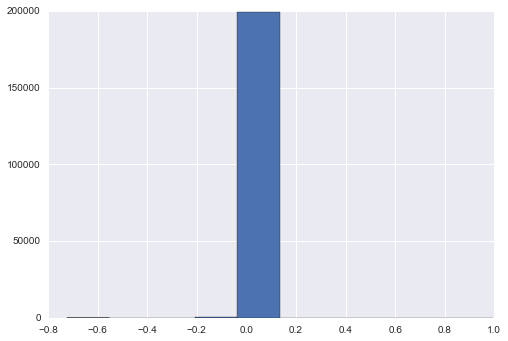

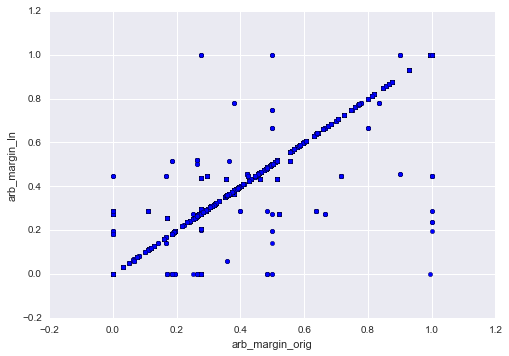

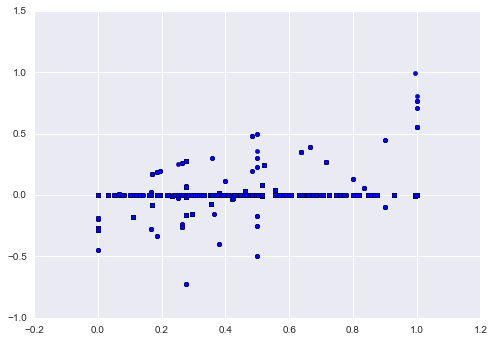

In [55]:
#Start of the fitting for SVM
#------------------------------
#cols = [2, 3, 5]
#t_cols = [df.columns[i] for i in cols]
#t_cols
#df[t_cols][:345]
#df.shape[1]
#dftrain_x = dftrain_x[:10000]
#dftrain_y = dftrain_y[:10000]

picks = list(range(dftrain_x.shape[1]))
#picks = [2]
#picks = [10]
#picks = [11]
picks = [13]
p_in_ar = []
#p_list = [13, 14]
#p_list = [2, 10]
#p_list = [15, 10]
p_list = [10, 11]
le_in_ar = []
    
le_out_ar = []
le_in_full = []
clf_ar = []
c_in_ar = []
l1 = 200000
l2 = 200
for p in p_list:
    t_le_in_ar = []
    t_le_out_ar = []
    t_p_in_ar = []
    t_clf = []
    t_c_in = []
    for i in range(1):
        print(dftrain_x.columns[p], i)

        x_train, _, y_train, _ = selectcols(dftrain_x[:l1], [p], 1.0, dftrain_y[:l1])
        x_test, _, y_test, _ = selectcols(dftest_x[:l2], [p], 1.0, dftest_y[:l2])
        #x_train.shape
        #x_test.shape
        #y_train.shape
        #y_test.shape

        #print(type(y_train))

        #rng = range(5, x_train.shape[1], 2)
        #rng = [2]
        #for i in rng:
        #    print(i)
        le_in, le_out, s_in, s_out, p_in, clf , c_in = sub_p_svm(x_train,y_train, x_test, y_test, 'all', 2, do_plot=False, label=dftrain_x.columns[p])
        t_le_in_ar.append(le_in)
        t_le_out_ar.append(le_out)
        t_p_in_ar.append(p_in)
        t_clf.append(clf)
        t_c_in.append(c_in)

        #plt.plot(le_in_ar, '-o',label="ll_in")
        #plt.plot(le_out_ar, '-o',label="ll_out")
        #plt.legend()

        #le_in_ar
        #le_out_ar
    le_in_full.append(t_le_in_ar)
    le_in_ar.append(np.mean(t_le_in_ar))
    le_out_ar.append(np.mean(t_le_out_ar))
    p_in_ar.append(t_p_in_ar)
    clf_ar.append(t_clf)
    c_in_ar.append(t_c_in)
    
print(np.shape(p_in_ar))
#print(p_in_ar)
p_in_ar = np.mean(p_in_ar, axis=1)

print("Resuts----------------------")
if(le_in_ar[0] <le_in_ar[1]):
    print("Best :", dftrain_x.columns[p_list[0]], " by ", le_in_ar[0] - le_in_ar[1])
else:
    print("Best :", dftrain_x.columns[p_list[1]], " by ", le_in_ar[1] - le_in_ar[0])
for i in range(len(p_list)):
    print(dftrain_x.columns[p_list[i]], le_in_ar[i])
p_comp = np.array(p_in_ar[0])-np.array(p_in_ar[1])
plt.figure()
plt.hist(p_comp)
plt.figure()
plt.scatter(p_in_ar[0], p_in_ar[1])
plt.xlabel(dftrain_x.columns[p_list[0]])
plt.ylabel(dftrain_x.columns[p_list[1]])
plt.figure()
plt.scatter(p_in_ar[0], p_comp)
#plt.figure()
#x_1, _, y_1, _ = selectcols(dftrain_x[:l1], [p], 1.0, dftrain_y[:l1])
#plt.scatter(x_1, p_in_ar[0])
#logloss
#target values
#0.48

#plot_confusion_matrix(cm, ["-1", "1"])

#select best features



['arb_margin_orig'] 200000
['arb_margin_ln'] 200000


(200000, 1)

(200000, 1)

array([[-1.31034205],
       [-2.80015272],
       [-1.3753056 ],
       [-1.19741072],
       [-1.20820481],
       [-1.28463002],
       [-1.23459259],
       [-1.29318864],
       [-3.34301262],
       [-1.24300281]])

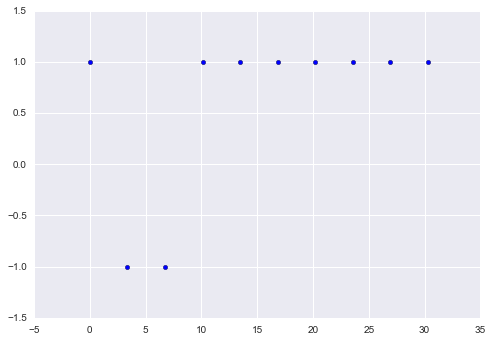

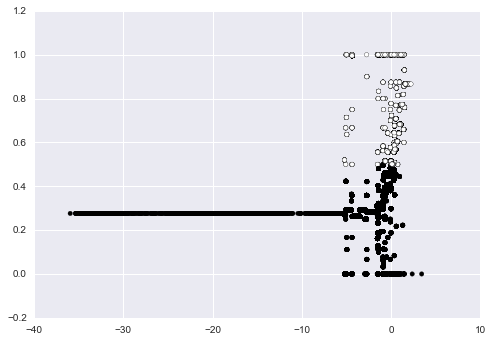

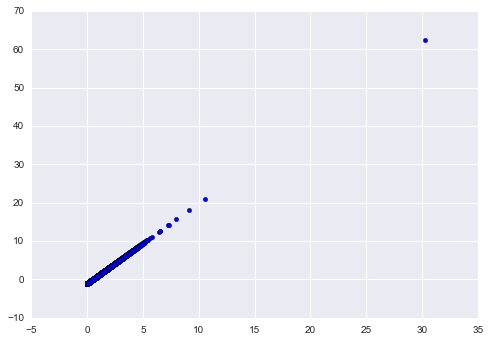

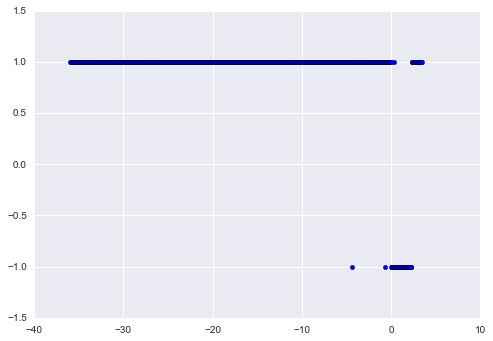

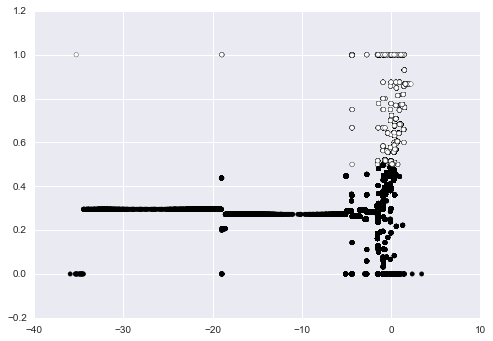

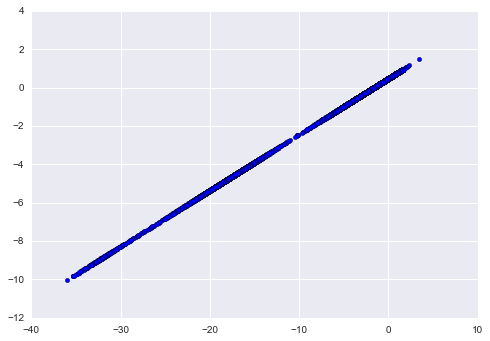

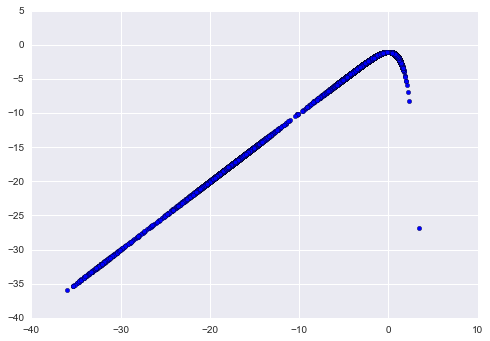

In [47]:
import treeinterpreter as ti
x_1, _, y_1, _ = selectcols(dftrain_x[:l1], [p_list[0]], 1.0, dftrain_y[:l1])
x_2, _, y_2, _ = selectcols(dftrain_x[:l1], [p_list[1]], 1.0, dftrain_y[:l1])

x_11 = StandardScaler().fit_transform(x_1)
ls1 = np.linspace(np.min(x_1)[0], np.max(x_1)[0],num=10)
#print(ls1[:30])
c1 = clf_ar[0][0].predict(ls1.reshape(ls1.shape[0], 1))
#lsr1=ls1.reshape(ls1.shape[0], 1)
#prediction, bias, contributions = ti.predict(clf_ar[0][0].best_estimator_.named_steps['RF'],lsr1)
#prediction
#bias
#contributions
#for i in range(len(lsr1)):
#    print ("Instance", i)
#    print ("Bias (trainset mean)", bias[i])
#    print ("Feature contributions:")
#    for c in sorted(contributions[i], key=lambda x: -abs(x[0])):
#        print (i, c)
#    print ("-"*20) 
    
plt.scatter(ls1, c1)
plt.figure()
#c_in_ar[0][0]
plt.scatter(np.log(x_1), p_in_ar[0], c=c_in_ar[0][0])
#plt.scatter(x_1, p_in_ar[0], c=y_1)
plt.figure()
plt.scatter(x_1, x_11)
plt.figure()
x_21 = StandardScaler().fit_transform(x_2)
ls2 = np.linspace(np.min(x_2)[0], np.max(x_2)[0],num=1000)
c2 = clf_ar[1][0].predict(ls2.reshape(ls2.shape[0], 1))
plt.scatter(ls2, c2)
plt.figure()
plt.scatter(x_2, p_in_ar[1], c=c_in_ar[1][0])
plt.figure()
plt.scatter(x_2, x_21)
plt.figure()
x_3 = np.array(x_2) - np.array(x_1)
np.shape(x_2)
np.shape(x_1)
x_3[:10]
plt.scatter(x_2, x_3)


In [48]:
import 
from treeinterpreter import treeinterpreter

SyntaxError: invalid syntax (<ipython-input-48-33ad9ef4159c>, line 1)

In [ ]:
import collections
c = collections.Counter(p_in_ar[0])
c.most_common(1)[0]
x_1, _, y_1, _ = selectcols(dftrain_x[:l1], [p_list[0]], 1.0, dftrain_y[:l1])
np.shape(x_1)
np.shape(p_in_ar[0])
#print(x_1)
f1 = []
f2 = []
f3 = []
v = c.most_common(1)[0][0]
for i in range(len(p_in_ar[0])):
    if math.isclose(p_in_ar[0][i],v,abs_tol=1e-10):
        f1.append(i)
        f2.append(x_1.iloc[i].values[0])
        
for i in range(np.shape(x_1)[0]):
    if x_1.iloc[i].values[0] >=0 and x_1.iloc[i].values[0] <=1:
        #f1.append(i)
        f3.append(x_1.iloc[i].values[0])

#f2[:20]
#f3[:20]
#np.shape(f2)
#np.shape(f3)
plt.scatter(f1[:2000],f2[:2000])

In [ ]:
all 0.498154878358 2.20879308212 lin
all 0.21245664321 5.55366657705 ln
all 0.212230499549 5.61829690965 log10

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          axis=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #thresh = cm[i].max() / 2.
        #thresh = orig.sum(axis=axis)[i]*0.5
        thresh = orig.sum()*0.5
        #print(i, j, thresh, orig[i,j])
        #col = "black"
        s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s,
                 horizontalalignment="center",
                 color="white" if orig[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
5
Scaling
Constructing Pipeline
Fitting
all 0.535125276345 0.547795834851